# Training  Word2Vec Embedding

Instead of training the embedding layer, we can first separately learn word embeddings and then pass to the embedding layer. This approach also allows to use any pre-trained word embedding and also saves the time in training the classification model.

### Step 1: Load the Dataset

In [1]:
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
df = pd.DataFrame()
df = pd.read_csv('movie_data.csv', encoding='utf-8')
df.head(3)

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1


Class Split
1    25000
0    25000
Name: sentiment, dtype: int64


Text(0, 0.5, 'Count')

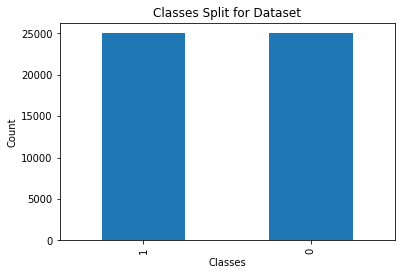

In [7]:
#Class Balance
print('Class Split')
print(df['sentiment'].value_counts())
df['sentiment'].value_counts().plot.bar(figsize=(6,4),title='Classes Split for Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')

### Step 2: Prepare the text corpus

The first step is to prepare the text corpus for learning the embedding by creating word tokens, removing punctuation, removing stop words etc. The word2vec algorithm processes documents sentence by sentence.

In [6]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

review_lines = list()
lines = df['review'].values.tolist()

for line in lines:   
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    review_lines.append(words)

In [7]:
len(review_lines)

50000

### Step 3: Word Embedding

Gensim’s Word2Vec API requires some parameters for initialization.

In [10]:
import gensim 
EMBEDDING_DIM = 100
# train word2vec model
model = gensim.models.Word2Vec(sentences=review_lines, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)
# vocab size
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 134095


In [11]:
#Save model in ASCII (word2vec) format
filename = 'imdb_embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

### Step 4: Test Word2Vec Model

In [13]:
# Let us try some utility functions of gensim word2vec 
model.wv.most_similar('horrible')

[('terrible', 0.9237805008888245),
 ('awful', 0.8649317026138306),
 ('horrendous', 0.7769838571548462),
 ('sucks', 0.7600740194320679),
 ('pathetic', 0.7443255186080933),
 ('lousy', 0.7442372441291809),
 ('dreadful', 0.7406150102615356),
 ('atrocious', 0.7363724112510681),
 ('horrid', 0.7342178821563721),
 ('bad', 0.7320282459259033)]

In [15]:
#Let’s see the result of semantically reasonable word vectors (king - man + woman)
model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

[('romeo', 0.9039229154586792),
 ('juliet', 0.8962530493736267),
 ('princess', 0.871935248374939),
 ('jerol', 0.8597689270973206),
 ('godmother', 0.8468965888023376),
 ('queen', 0.8447667360305786),
 ('mtvfashioned', 0.8424580097198486),
 ('shepis', 0.8379086852073669),
 ('carmen', 0.8372462391853333),
 ('manwife', 0.8339641690254211)]

In [18]:
#odd word out
print(model.wv.doesnt_match("woman king queen movie".split()))

movie


In [21]:
#odd word out
print(model.wv.doesnt_match("man king women people ".split()))

king


In [22]:
model.wv.similar_by_word("cat")

[('mouse', 0.8166879415512085),
 ('dog', 0.7927877306938171),
 ('dude', 0.7037979364395142),
 ('monkey', 0.7003536820411682),
 ('hat', 0.695722222328186),
 ('pet', 0.6832510828971863),
 ('rabbit', 0.6791969537734985),
 ('snake', 0.6791744828224182),
 ('fraidy', 0.6790204048156738),
 ('bugs', 0.6738077402114868)]

In [24]:
print(model.similarity('boy', 'girl'))

0.8268802


C:\Users\noopa\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


### Step 4: Model Training 

Use Pre-trained Embedding to train the model.Since we have already trained word2vec model with IMDb dataset, we have the word embeddings ready to use. The next step is to load the word embedding as a directory of words to vectors. The word embedding was saved in file imdb_embedding_word2vec.txt. Let us extract the word embeddings from the stored file.

In [29]:
#import os

embeddings_index = {}
f = open(os.path.join('', 'imdb_embedding_word2vec.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()


The next step is to convert the word embedding into tokenized vector. Recall that the review documents are integer encoded prior to passing them to the Embedding layer. The integer maps to the index of a specific vector in the embedding layer. Therefore, it is important that we lay the vectors out in the Embedding layer such that the encoded words map to the correct vector.

In [30]:
max_length = 100
# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences = tokenizer_obj.texts_to_sequences(review_lines)

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
sentiment =  df['sentiment'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

Found 134095 unique tokens.
Shape of review tensor: (50000, 100)
Shape of sentiment tensor: (50000,)


Now we will map embeddings from the loaded word2vec model for each word to the *tokenizer_obj.word_index* vocabulary and create a matrix with of word vectors

In [31]:
EMBEDDING_DIM =100
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [18]:
print(num_words)

134096


In [32]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

# define model
model = Sequential()
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          13409600  
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,422,401
Trainable params: 12,801
Non-trainable params: 13,409,600
_________________________________________________________________
None


You can see that model total params = 13,422,401 but trainable params = 12801. Since the model uses pre-trained word embedding it has very few trainable params and hence should train faster.

In [33]:
# split the data into a training set and a validation set
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = sentiment[indices]
num_validation_samples = int(VALIDATION_SPLIT * review_pad.shape[0])

X_train_pad = review_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

In [34]:
print('Shape of X_train_pad tensor:', X_train_pad.shape)
print('Shape of y_train tensor:', y_train.shape)

print('Shape of X_test_pad tensor:', X_test_pad.shape)
print('Shape of y_test tensor:', y_test.shape)

Shape of X_train_pad tensor: (40000, 100)
Shape of y_train tensor: (40000,)
Shape of X_test_pad tensor: (10000, 100)
Shape of y_test tensor: (10000,)


In [35]:
print('Train...')

model.fit(X_train_pad, y_train, batch_size=128, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Train...
Train on 40000 samples, validate on 10000 samples
Epoch 1/25
 - 13s - loss: 0.6620 - accuracy: 0.6352 - val_loss: 0.6051 - val_accuracy: 0.6695
Epoch 2/25
 - 12s - loss: 0.5859 - accuracy: 0.6956 - val_loss: 0.5780 - val_accuracy: 0.6976
Epoch 3/25
 - 13s - loss: 0.5834 - accuracy: 0.7084 - val_loss: 0.5967 - val_accuracy: 0.6813
Epoch 4/25
 - 13s - loss: 0.5730 - accuracy: 0.7174 - val_loss: 0.5923 - val_accuracy: 0.6837
Epoch 5/25
 - 12s - loss: 0.5463 - accuracy: 0.7279 - val_loss: 0.5774 - val_accuracy: 0.7011
Epoch 6/25
 - 12s - loss: 0.5314 - accuracy: 0.7385 - val_loss: 0.5677 - val_accuracy: 0.7077
Epoch 7/25
 - 13s - loss: 0.5171 - accuracy: 0.7551 - val_loss: 0.5655 - val_accuracy: 0.7143
Epoch 8/25
 - 13s - loss: 0.6299 - accuracy: 0.7442 - val_loss: 0.5803 - val_accuracy: 0.6993
Epoch 9/25
 - 12s - loss: 0.5614 - accuracy: 0.7369 - val_loss: 0.5705 - val_accuracy: 0.7064
Epoch 10/25
 - 12s - loss: 0.5332 - accuracy: 0.7515 - val_loss: 0.5672 - val_accuracy: 0.7130


In [38]:
print('Testing...')
score, acc = model.evaluate(X_test_pad, y_test, batch_size=128)

print('Validation Loss:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

Testing...
10000/10000 [==============================] - 1s 112us/step
Validation Loss: 0.5680101370811462
Test accuracy: 0.7159000039100647
Accuracy: 71.59%


In [40]:
#Let us test some  samples
# load the dataset but only keep the top n words, zero the rest

test_sample_1 = "This movie is fantastic! I really like it because it is so good!"
test_sample_2 = "Good movie!"
test_sample_3 = "Maybe I like this movie."
test_sample_4 = "Not to my taste, will skip and watch another movie"
test_sample_5 = "if you like action, then this movie might be good for you."
test_sample_6 = "Bad movie!"
test_sample_7 = "Not a good movie!"
test_sample_8 = "This movie really sucks! Can I get my money back please?"
test_samples = [test_sample_1, test_sample_2, test_sample_3, test_sample_4, test_sample_5, test_sample_6, test_sample_7, test_sample_8]

test_samples_tokens = tokenizer_obj.texts_to_sequences(test_samples)
test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=100)

#predict
model.predict(x=test_samples_tokens_pad)

array([[0.6387844 ],
       [0.55495757],
       [0.5035512 ],
       [0.3968063 ],
       [0.49933943],
       [0.24318704],
       [0.55495757],
       [0.32361543]], dtype=float32)

In [41]:
#let us check how the model predicts
classes = model.predict(X_test_pad[:10], batch_size=128)
for i in range (0,10):
    if(classes[i] > 0.5 and y_test[i] == 1 or (classes[i] <= 0.5 and y_test[i] == 0)):
        print( classes[i], y_test[i], " Right prdiction")
    else :
        print( classes[i], y_test[i], " Wrong prdiction")

[0.28751183] 0  Right prdiction
[0.6935145] 1  Right prdiction
[0.8876598] 1  Right prdiction
[0.6565224] 1  Right prdiction
[0.55315673] 0  Wrong prdiction
[0.5464764] 0  Wrong prdiction
[0.16490605] 0  Right prdiction
[0.6375148] 0  Wrong prdiction
[0.54393625] 1  Right prdiction
[0.63414353] 0  Wrong prdiction
